In [19]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import resample
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from nltk.classify.scikitlearn import SklearnClassifier
from nltk.classify import ClassifierI
import math
import random
import pickle
from statistics import mode

We declare a function, clean_comment, to regex and tokenize comments.

In [20]:
stop_words = set(stopwords.words("english"))

def clean_comment(comment):
    ps = PorterStemmer()
    regex = re.compile('[^ a-zA-Z]')
    cleaned_comment = regex.sub('', comment)
    tokenized_words = word_tokenize(cleaned_comment.lower())
    cleaned_comments = []

    for word in tokenized_words:
        if word not in stop_words:
            cleaned_comments.append(ps.stem(word))

    return cleaned_comments

We start by creating a df of our sample data.

In [21]:
df = pd.read_csv('stock_data.csv', sep=',', encoding='latin-1')

Let us look into class balance in the above df.

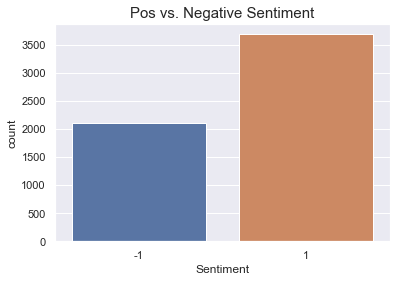

In [22]:
plt.figure(figsize = None)
sns.set_theme(style="darkgrid")
sns.countplot(x="Sentiment", data=df)
plt.title("Pos vs. Negative Sentiment", fontsize = 15)
plt.show()

Based on the above, we need to upsample our negative sentiment.

In [23]:
df_majority = df[df['Sentiment'] == 1]
df_minority = df[df['Sentiment'] == -1]

minority_upsample = resample(df_minority, replace = True, n_samples = df_majority.shape[0], random_state=101)

df_upsampled = pd.concat([minority_upsample, df_majority])
df_upsampled = df_upsampled.sample(frac=1)

Check our upsample

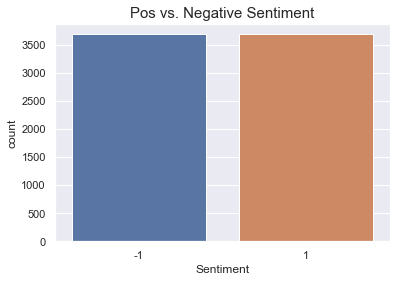

In [24]:
plt.figure(figsize = None)
sns.set_theme(style="darkgrid")
sns.countplot(x="Sentiment", data=df_upsampled)
plt.title("Pos vs. Negative Sentiment", fontsize = 15)
plt.show()

In [25]:
print(df_upsampled)

                                                   Text  Sentiment
5524  Mukesh Ambani's Net Worth Drops To $48 Billion...         -1
2243                               P is breaking out.            1
843                            AAP  100 week support            -1
3544  user calling for rotation out of everything ba...          1
3451  user: AAP Who is gonna trade in their watch fo...          1
...                                                 ...        ...
5309  RT @srussolillo: This is absolutely terrifying...         -1
1629  AAP DownTend seem confirmed after broken the t...         -1
1413  DA volume decreasing looking for start of the ...         -1
3560  Equity Alpha: INFA is our fav short opp. No gr...         -1
3803  PETM short hit my 2nd tgt, took more off, fina...         -1

[7370 rows x 2 columns]


 We begin by compiling a feature list of words from our positive and negative comments to begin to see trends in which words fall into which category generally.

We begin by building a frequency distribution of words in our comments. We can also use this to build our vocab.

In [26]:
# TASK CELL
def word_counter(comments, sentiment):
    '''
    Params:
        comments: a list of comments
        sentiment: a list corresponding to the sentiment of each message (either 0 or 1)
    Return:
        output_occurence: a dictionary mapping each pair to its frequency
    '''

    output_occurence = {}
    vocab = []


    for label, comment in zip(sentiment, comments):
        for word in clean_comment(comment):
            vocab.append(word)
            composite_key = (word, label)
            keys = output_occurence.keys()
            if composite_key in keys:
                output_occurence[composite_key] += 1
            else:
                output_occurence[composite_key] = 1

    vocab = set(vocab)
    
    return output_occurence, vocab

In [27]:
#random.shuffle(documents)
#print(documents[0])
vocab = []
comments = []
sentiments = []
documents = []

for comment in df_upsampled['Text']:
    comments.append(clean_comment(comment))

for sentiment in df_upsampled['Sentiment']:
    sentiments.append(sentiment)

for i in range(len(comments)):
    documents.append((comments[i], sentiments[i]))

random.shuffle(documents)

for comment in comments:
    for word in comment:
        vocab.append(word)

vocab = nltk.FreqDist(vocab)

vocab_features = list(vocab.keys())

print(documents[0][0])


['mcp', 'either', 'way', 'candl', 'back', 'next', 'week', 'set', 'tone', 'way', 'overal', 'investor', 'sentiment', 'want', 'take']


Now, we categorize each word as positive or negative. We build a function that finds words in our comments and gets their most frequent classification from the dictionary created in find_occurence.

In [28]:
def find_features(comment):
    '''
    Params:
        document: our comment and sentiment
    Return:
        the features, a dictionary of words in the comment mapped to sentiment
    '''
    words = comment
    features = {}

    for w in vocab_features:
        features[w] = (w in words)

    return features
    
        



In [29]:
featuresets = [(find_features(comment), sentiment) for (comment, sentiment) in documents]

print(featuresets[1])

({'mukesh': False, 'ambani': False, 'net': False, 'worth': False, 'drop': False, 'billion': False, 'month': False, 'amid': False, 'coronaviru': False, 'crisishttpstcottjumldfu': False, 'p': False, 'break': False, 'aap': False, 'week': False, 'support': False, 'user': False, 'call': False, 'rotat': False, 'everyth': False, 'back': False, 'everybodi': False, 'cat': False, 'gon': False, 'na': False, 'trade': False, 'watch': False, 'iwatch': False, 'actual': False, 'iphon': False, 'mtx': False, 'attack': False, 'multi': False, 'year': False, 'high': False, 'entri': False, 'stop': False, 'vvtv': False, 'bought': False, 'long': False, 'wealth': False, 'posit': False, 'overnight': False, 'xma': False, 'column': False, 'ebay': False, 'finviz': False, 'sell': False, 'travel': False, 'hospit': False, 'take': False, 'time': False, 'recov': False, 'post': False, 'lockdown': False, 'expertshttpstcoilkyxeesnb': False, 'new': False, 'earn': False, 'cost': False, 'contain': False, 'continu': False, 'p

Let us see how this works on our training data.

In [30]:
cutoff = round(len(featuresets) * 0.8)
training_set = featuresets[:cutoff]
testing_set = featuresets[cutoff+1:]

naive_bayes_classifier = nltk.NaiveBayesClassifier.train(training_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(naive_bayes_classifier, testing_set))*100)


Classifier accuracy percent: 80.04073319755601


We can see our most influential words below.

In [31]:
naive_bayes_classifier.show_most_informative_features(15)

Most Informative Features
                    rupe = True               -1 : 1      =     16.0 : 1.0
                   crash = True               -1 : 1      =     14.6 : 1.0
                   slump = True               -1 : 1      =     14.6 : 1.0
               watchlist = True                1 : -1     =     14.0 : 1.0
                    nvda = True                1 : -1     =     12.1 : 1.0
                    shot = True               -1 : 1      =     11.8 : 1.0
                 bearish = True               -1 : 1      =     10.6 : 1.0
                    gevo = True                1 : -1     =     10.6 : 1.0
                     vxi = True               -1 : 1      =      9.6 : 1.0
                     ead = True               -1 : 1      =      9.4 : 1.0
                       r = True               -1 : 1      =      9.4 : 1.0
                  travel = True               -1 : 1      =      9.4 : 1.0
                     esf = True               -1 : 1      =      9.3 : 1.0

Excellent, we have an accuracy of 82%! Now, we should save this classifier to use when voting later.

In [32]:
save_classifier = open('naivebayes.pickle','wb')
pickle.dump(naive_bayes_classifier, save_classifier)
save_classifier.close()

Other classifiers - this may take a substantial amount of time to run.

In [33]:
MNB_classifier = SklearnClassifier(MultinomialNB())
MNB_classifier.train(training_set)

BNB_classifier = SklearnClassifier(BernoulliNB())
BNB_classifier.train(training_set)

LogisticRegression_classifier = SklearnClassifier(LogisticRegression())
LogisticRegression_classifier.train(training_set)

SGDClassifier_classifier = SklearnClassifier(SGDClassifier())
SGDClassifier_classifier.train(training_set)

SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(training_set)

LinearSVC_classifier = SklearnClassifier(LinearSVC())
LinearSVC_classifier.train(training_set)

NuSVC_classifier = SklearnClassifier(NuSVC())
NuSVC_classifier.train(training_set)

<SklearnClassifier(NuSVC())>

Let's check the accuracy of the above models.

In [34]:
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_classifier, testing_set))*100)
print("BNB accuracy percent:", (nltk.classify.accuracy(BNB_classifier, testing_set))*100)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogisticRegression_classifier, testing_set))*100)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGDClassifier_classifier, testing_set))*100)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_classifier, testing_set))*100)
print("LinearSVC_classifier accuracy percent:", (nltk.classify.accuracy(LinearSVC_classifier, testing_set))*100)
print("NuSVC_classifier accuracy percent:", (nltk.classify.accuracy(NuSVC_classifier, testing_set))*100)


MNB_classifier accuracy percent: 80.10862186014936
BNB accuracy percent: 79.83706720977597
LogisticRegression_classifier accuracy percent: 83.5030549898167
SGDClassifier_classifier accuracy percent: 84.65716225390359
SVC_classifier accuracy percent: 86.693822131704
LinearSVC_classifier accuracy percent: 86.01493550577054
NuSVC_classifier accuracy percent: 87.16904276985743


Declaration of our vote classifier class

In [37]:
class VotingClassifier(ClassifierI):
    def __init__(self, *classifiers):
        self._classifiers = classifiers

    def classify(self, features):
        votes = []
        for classifier in self._classifiers:
            vote = classifier.classify(features)
            votes.append(vote)
        return mode(votes)

    def evaluate_confidence(self, features):
        votes = []
        for classifier in self._classifiers:
            vote = classifier.classify(features)
            votes.append(vote)
            
        choice_votes = votes.count(mode(votes))
        confidence = choice_votes / len(votes)
        return confidence




In [38]:
voting_classifier = VotingClassifier(naive_bayes_classifier, MNB_classifier, BNB_classifier, LogisticRegression_classifier, SGDClassifier_classifier, SVC_classifier, LinearSVC_classifier, NuSVC_classifier)
print("voted_classifier accuracy percent:", (nltk.classify.accuracy(voting_classifier, testing_set))*100)


NotImplementedError: 